In [1]:
# =========================
# Libraries
# =========================

import numpy as np
import pandas as pd
from scipy.integrate import trapezoid, cumulative_trapezoid
import emcee
from multiprocessing import Pool
import multiprocessing as mp
from getdist import MCSamples, plots
import matplotlib.pyplot as plt

In [2]:
# =========================
# Loading FRB data
# =========================

# Path
frb_dat_path = "/home/brunowesley/projetos/MCMC-cosmo/Data/FRB/frb_catalog.txt"

# DataFrame
df_frb = pd.read_csv(frb_dat_path, sep=r"\t", engine='python')

# Sort data by redshift
df_frb = df_frb.sort_values(by="Redshift", ascending=True)

# Reset index after sorting
df_frb = df_frb.reset_index(drop=True)

# Main columns
z_frb   = df_frb["Redshift"].to_numpy(float)
DM_obs  = df_frb["DM_obs"].to_numpy(float)
DM_MW   = df_frb["DM_MW_ISM_(NE2001)"].to_numpy(float)

# Milky Way halo contribution to the dispersion measure (literature value)
DM_halo_mean = 50

# Total Milky Way contribution to the dispersion measure
DM_MW_total = DM_MW + DM_halo_mean

# Extragalactic dispersion measure (IGM + host)
DM_ext_obs = DM_obs - DM_MW_total

In [3]:
# =========================
# Fiducial
# =========================

# Uniform priors 
H0_min, H0_max = 50., 90.
Om0_min, Om0_max = 0.1, 0.6
sig_host_min, sig_host_max = 0.2, 2.0
e_mu_min, e_mu_max = 20., 200.

# Gaussian prior
mu_Ob, sigma_Ob = 0.0495, 0.0025

# Physical constants (in SI units)
c_si = 2.99792458e8
G_si = 6.67430e-11
mp_si = 1.67262192369e-27

# Cosmological/astrophysical parameters
Or0 = 7.88e-5
f_IGM = 0.83
chi_e = 0.875

# Redshift grid
z_grid = np.linspace(0, 2.5, 1000)

In [6]:
# ==============================
# Hubble functions
# ==============================

# Normalized Hubble parameter
def E_LCDM(z, Om0):

    # Matter density parameter
    Om = Om0 * (1 + z)**3

    # Radiation density parameter
    Or = Or0 * (1 + z)**4

    # Cosmological constant density
    Ol0 = 1 - Om0 - Or0

    return np.sqrt(Om + Or + Ol0)


# Hubble parameter
def H_LCDM(z, H0, Om0):
    return H0 * E_LCDM(z, Om0)

In [7]:
# =========================
# Theoretical IGM dispersion measure
# =========================

def DM_IGM_LCDM(z_frb, H0, Om0, Ob):

    # Prefactor
    A = 3 * c_si * f_IGM * chi_e / (8 * np.pi * G_si * mp_si) 
    
    # Normalized Hubble parameter
    E_grid = E_LCDM(z_grid, Om0)
    
    # Integrand of the DM_IGM redshift integral
    integrand = (1 + z_grid) / E_grid

    # Cumulative integral over redshift
    I = cumulative_trapezoid(integrand, z_grid, initial=0.0)

    # Dispersion measure before unit conversion
    DM_IGM_prime = A * Ob * H0 * I

    # Unit conversion factors
    km_to_pc = 1/(3.0857e13)
    m2_to_cm2 = 1e4
    Mpc_to_cm = 3.0857e24

    # Dispersion measure in physical units (pc cm^-3)
    DM_IGM_corr = DM_IGM_prime * (km_to_pc / (m2_to_cm2 * Mpc_to_cm))

    # Interpolate DM_IGM(z) at the FRB redshifts
    DM_IGM_theo = np.interp(z_frb, z_grid, DM_IGM_corr)

    return DM_IGM_theo


# ========================
# Sanity test
# ========================

print("DM_IGM_LCDM(z_frb) =", DM_IGM_LCDM(z_frb, 70, 0.3, 0.0495))

DM_IGM_LCDM(z_frb) = [   7.21817334   16.17985646   20.1952993    25.44873739   25.82744456
   36.61179457   36.88131537   40.22844646   51.84339241   55.13058944
   55.48054081   56.79369668   60.38724159   61.54596311   61.70398006
   62.93332358   67.6830176    77.48143521   80.22610864   81.46715841
   85.10499424   91.33037514   93.78100128   93.91480529   95.78806148
   99.27150801  102.7420022   103.29725931  103.38681691  106.79190805
  106.91741086  110.56153765  111.01062598  113.07786266  113.70718502
  121.27431561  124.07286578  128.50276131  138.02146092  138.11226715
  139.23781387  141.56587686  156.52192033  162.65532972  169.90391966
  170.63878084  170.75822227  181.50155367  186.66999506  188.05601497
  190.82953078  204.26832814  208.91485678  211.24046346  214.0331975
  215.80032506  216.64171912  217.48059487  219.15888284  224.29192942
  224.47876334  235.51589322  243.48608262  248.55775379  250.53173592
  251.66014851  256.3360478   258.53135583  262.48968078 

In [ ]:
# =========================
# FRB Likelihood
# =========================

# Log-priors
def lnprior_frb(theta_frb):

    # Params vector
    H0, Om0, Ob, sigma_host, exp_mu = theta_frb
    
    # Flat priors
    if not (H0_min <= H0 <= H0_max):                     return -np.inf
    if not (Om0_min <= Om0 <= Om0_max):                  return -np.inf
    if not (sig_host_min <= sigma_host <= sig_host_max): return -np.inf
    if not (e_mu_min <= exp_mu <= e_mu_max):             return -np.inf
   
    # Gaussion prior on Omega_b
    lp_Ob = -0.5 * ((Ob - mu_Ob) / sigma_Ob)**2 - np.log(sigma_Ob * np.sqrt(2.0 * np.pi))

    return lp_Ob


# Convolved FRB PDF: IGM (Gaussian) + host galaxy (log-normal)
def P_DM_ext_vectorized(z_frb, DM_ext_obs, DM_IGM_mean, sigma_IGM, sigma_host, exp_mu, npts=600):
    
    # Number of FRBs
    N = len(DM_ext_obs)

    # Log-normal mean of the host contribution
    mu_host = np.log(exp_mu)

    # DM_host integration grid
    DM_hosp_grid = np.linspace(1e-5, DM_ext_obs.max(), npts)   # (npts,)
    DM_hosp_grid = DM_hosp_grid[None, :]                       # (1, npts)

    # Observed extragalactic DM
    DM_ext_array = DM_ext_obs[:, None]  # (N, 1)

    # DM_IGM for each host contribution
    DM_IGM_array = DM_ext_array - DM_hosp_grid / (1 + z_frb[:, None])  # (N, npts)

    # IGM dispersion
    sigma_IGM_array = sigma_IGM[:, None]
    
    # DM_IGM mean
    DM_IGM_mean_array = DM_IGM_mean[:, None]
    
    # IGM PDF (Gaussian)
    P_IGM = (1.0 / (np.sqrt(2*np.pi) * sigma_IGM_array)) \
            * np.exp(-0.5 * ((DM_IGM_array - DM_IGM_mean_array)/sigma_IGM_array)**2)

    # Host galaxy PDF (log-normal)
    DM_hosp_array = DM_hosp_grid
    P_host = (1.0 / (np.sqrt(2*np.pi) * sigma_host * DM_hosp_array)) \
             * np.exp(-0.5 * ((np.log(DM_hosp_array) - mu_host)/sigma_host)**2)

    # Product of IGM and host PDFs
    integrand = P_IGM * P_host  # (N, npts)

    # Marginalization over DM_host
    P_total = trapezoid(integrand, x=DM_hosp_array, axis=1)

    # Avoid log(0)
    return np.maximum(P_total, 1e-100)


# Log-likelihood
def lnlike_frb(theta_frb, z_frb, DM_ext_obs, npts=1000):
    H0, O_m0, Ob, sigma_host, exp_mu = theta_frb

    # Theoretical mean IGM Dispersion measure
    DM_IGM_mean = DM_IGM_LCDM(z_frb, H0, O_m0, Ob)

    # Empirical IGM scatter
    sigma_IGM = 173.8 * (z_frb**0.4)

    # IGM + host convolution
    P_total = P_DM_ext_vectorized(z_frb, DM_ext_obs, DM_IGM_mean,
                                  sigma_IGM, sigma_host, exp_mu, npts=npts)

    return np.sum(np.log(P_total))


# Log-posterior
def lnprob_frb(theta_frb, z_frb, DM_ext_obs):
    
    # Log-prior
    lp = lnprior_frb(theta_frb)
    if not np.isfinite(lp):
        return -np.inf

    # Log-likelihood
    ll = lnlike_frb(theta_frb, z_frb, DM_ext_obs, npts=1000)

    return lp + ll


# =========================
# Quick test
# =========================

theta_frb_test = [70, 0.3, 0.0494, 0.7, 120]
print("LCDM_FRB log-posterior =", lnprob_frb(theta_frb_test, z_frb, DM_ext_obs))

LCDM_FRB log-posterior = -645.068856497968


In [ ]:
# =========================
# MCMC configuration
# =========================

# Dimensions and sampling settings
ndim, nwalkers, nsteps, nburn = 5, 40, 53500, 3500
rng = np.random.default_rng(42)

# Initial walker positions drawn from priors
p0 = np.zeros((nwalkers, ndim))
p0[:,0] = rng.uniform(H0_min,H0_max,nwalkers)               # H0
p0[:,1] = rng.uniform(Om0_min,Om0_max,nwalkers)             # Om0
p0[:,2] = rng.normal(mu_Ob,sigma_Ob,nwalkers)               # Ob
p0[:,3] = rng.uniform(sig_host_min,sig_host_max,nwalkers)   # sigma_host
p0[:,4] = rng.uniform(e_mu_min,e_mu_max,nwalkers)           # exp_mu


# Parallel chain generation (MORE efficient for LCDM_FRB)
with mp.Pool(processes=nwalkers) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_frb, args=(z_frb, DM_ext_obs), pool=pool)
    sampler.run_mcmc(p0, nsteps, progress=True)

# Single-threaded chain generation (LESS efficient for LCDM_FRB)
# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_bao, args=(z_bao, d_obs, Cinv_bao))
# sampler.run_mcmc(p0, nsteps, progress=True)


# Full chain: shape (nsteps, nwalkers, ndim)
chain = sampler.get_chain()
# np.save("chain_LCDM_frb.npy", chain)

# Flattened chain after burn-in: shape (N_total, ndim)
flat_samples = sampler.get_chain(discard=nburn, flat=True)
np.save("flat_samples_LCDM_frb.npy", flat_samples)

100%|██████████| 53500/53500 [09:13<00:00, 96.74it/s] 


Removed no burn in


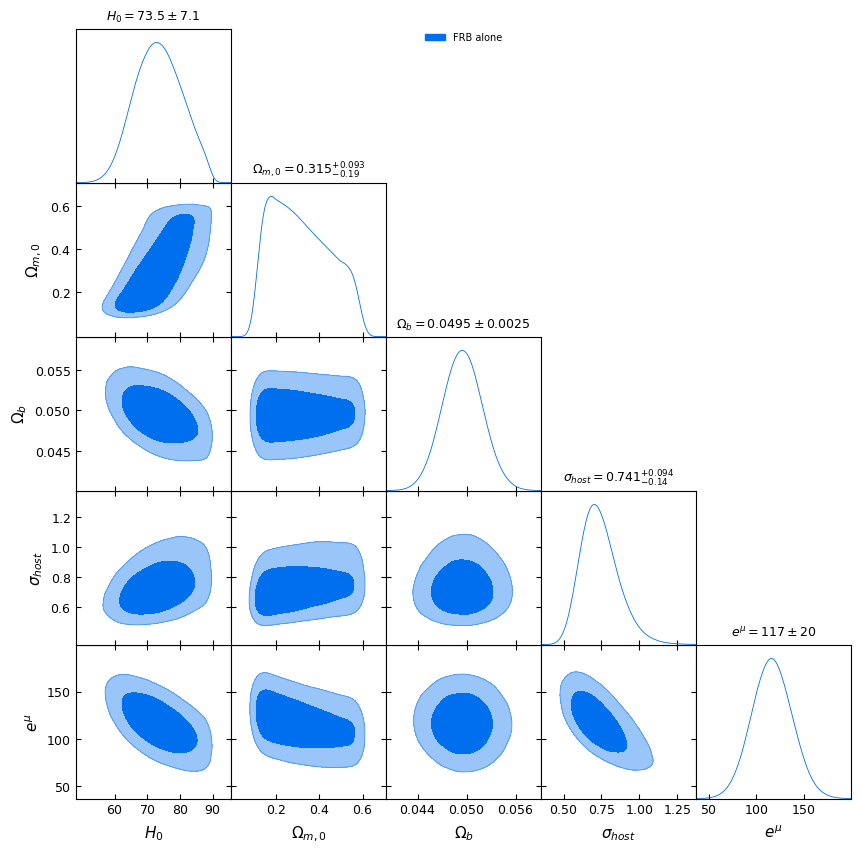

In [ ]:
# =========================
# Corner plot using GetDist
# =========================

# Parameter names and LaTeX labels
param_names  = ["H0", "Omega_m0", "Omega_b", "sigma_host", "exp_mu"]
param_labels = [r"H_0", r"\Omega_{m,0}", r"\Omega_b", r"\sigma_{host}", r"e^\mu"]


# Create GetDist samples object
samples = MCSamples(
    samples=flat_samples,
    names=param_names,
    labels=param_labels
)

# Smoothing and binning settings
samples.updateSettings({
    "smooth_scale_1D": 0.25,
    "smooth_scale_2D": 0.25,
    "fine_bins": 1024,
    "fine_bins_2D": 1024

})

# Parameter ranges (optional)
# samples.setRanges({
#     "param p1": (p1_min, p1_max),
#     "param p2": (p2_min, p2_max),
#     "param p3": (p3_min, p3_max)
# })


# Initialize GetDist subplot plotter
g = plots.get_subplot_plotter()

# Plot styling settings
g.settings.axes_fontsize = 12
g.settings.lab_fontsize = 14
g.settings.legend_fontsize = 10
g.settings.linewidth_contour = 1.2
g.settings.num_plot_contours = 2
g.settings.axis_marker_lw = 1.0
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.3


# Triangle (corner) plot
g.triangle_plot(
    samples,
    filled=True,
    legend_labels=["FRB alone"],
    #contour_colors=["#"],
    title_limit=1
)

# Save figure
plt.savefig("triangle_LCDM_frb.png", dpi=300, bbox_inches="tight")
plt.show()